# Dementia Evaluation

In [1]:
import os, random, time, numpy as np, pandas as pd, copy
import tensorflow as tf
from tensorflow import losses, optimizers, metrics
from tensorflow.keras import Input, Model, layers, callbacks, regularizers, models
from jarvis.train import custom, datasets, params
from jarvis.train.client import Client
from jarvis.utils.general import gpus, overload, tools as jtools
from jarvis.utils.display import imshow

In [2]:
# --- Autoselect GPU
gpus.autoselect()

[ 2021-08-18 21:34:27 ] WARNING 1 GPU device(s) requested but only 0 available 


In [3]:
# --- Initialize client
client = Client('/home/mmorelan/proj/dementia/yml/client-3d-96x128.yml', configs={'batch': {'fold': 0}})

In [4]:
# --- Load contrastive model
pretrained_model = models.load_model("./pretrained_models/encoder_decoder/model.hdf5", compile=False, custom_objects={"tf": tf})
pretrained_model.summary()

/miniconda/envs/jarvis/lib/python3.8/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: loss is not loaded, but a Lambda layer uses it. It may cause errors.
  warnings.warn('{} is not loaded, but a Lambda layer uses it. '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pos (InputLayer)                [(None, 96, 128, 128 0                                            
__________________________________________________________________________________________________
unk (InputLayer)                [(None, 96, 128, 128 0                                            
__________________________________________________________________________________________________
neg (InputLayer)                [(None, 96, 128, 128 0                                            
__________________________________________________________________________________________________
model (Functional)              {'ctr': (None, 10),  199978      pos[0][0]                        
                                                                 unk[0][0]                  

In [116]:
pretrained_model.input

{'pos': <KerasTensor: shape=(None, 96, 128, 128, 1) dtype=float32 (created by layer 'pos')>,
 'unk': <KerasTensor: shape=(None, 96, 128, 128, 1) dtype=float32 (created by layer 'unk')>,
 'neg': <KerasTensor: shape=(None, 96, 128, 128, 1) dtype=float32 (created by layer 'neg')>}

In [117]:
# --- Get single input model
enc_model = Model(inputs=pretrained_model.input['unk'], outputs=pretrained_model.get_layer('enc2').output)
dec_model = Model(inputs=pretrained_model.input['unk'], outputs=pretrained_model.get_layer('dec2').output)

In [118]:
enc_model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unk (InputLayer)             [(None, 96, 128, 128, 1)] 0         
_________________________________________________________________
model (Functional)           {'ctr': (None, 10), 'enc' 199978    
_________________________________________________________________
enc2 (Layer)                 (None, 1)                 0         
Total params: 199,978
Trainable params: 199,658
Non-trainable params: 320
_________________________________________________________________


In [119]:
dec_model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unk (InputLayer)             [(None, 96, 128, 128, 1)] 0         
_________________________________________________________________
model (Functional)           {'ctr': (None, 10), 'enc' 199978    
_________________________________________________________________
dec2 (Layer)                 (None, 96, 128, 128, 1)   0         
Total params: 199,978
Trainable params: 199,658
Non-trainable params: 320
_________________________________________________________________


In [120]:
# --- Create validation generator
test_train, test_valid = client.create_generators(test=True)

In [121]:
# --- Aggregate all examples
xs = []
ys = []

for x, y in test_valid:
    xs.append(x['dat'])
    ys.append(y['lbl'])

xs = np.concatenate(xs)
ys = np.concatenate(ys)

[ 2021-08-18 20:52:27 ] [====================] 100.000% : Iterating | 000669    

In [122]:
# --- Run prediction over all samples (takes some time, recommend to subsample the data...)
logits = {'enc2': enc_model.predict(xs), 'dec2': dec_model.predict(xs)}

In [179]:
# --- Calculate metrics

def classification(true, y_pred):
    # --- Binarize probability predictions using a 0.5 threshold
    pred = copy.deepcopy(y_pred)
    pred[pred < 0.5] = 0
    pred[pred >= 0.5] = 1
    
    df = pd.DataFrame()
    df['pred'] = np.squeeze(pred)
    df['true'] = np.squeeze(true)
    df['corr'] = df['pred'] == df['true']
    
    return df


def reconstruction(true, y_pred):
    assert len(true) == len(y_pred)
    
    df = pd.DataFrame()
    df['mae'] = np.array([np.mean(abs(true - y_pred))])
    df['mse'] = np.array([np.mean((true - y_pred)**2)])
    
    return df

In [180]:
# --- Reconstruction Accuracy
df = reconstruction(xs[0:10], logits['dec2'][0:10])

# --- Classification Accuracy 
acc = classification(ys, logits['enc2'])
df['mean_acc'] = acc['corr'].mean()
df['median_acc'] = np.median(acc['corr'])

df

,mae,mse,mean_acc,median_acc
0,0.142299,0.043671,0.831091,1.0


In [194]:
def show_reconstruction(true, pred, figsize=(10, 10)):

    imshow(true, figsize=figsize)
    
    if pred.shape == 4:
        imshow(pred[None, :], figsize=figsize)
        imshow(true, pred[None, :], figsize=figsize) # overlay
    else:
        imshow(pred, figsize=figsize)
        imshow(true, pred, figsize=figsize) # overlay

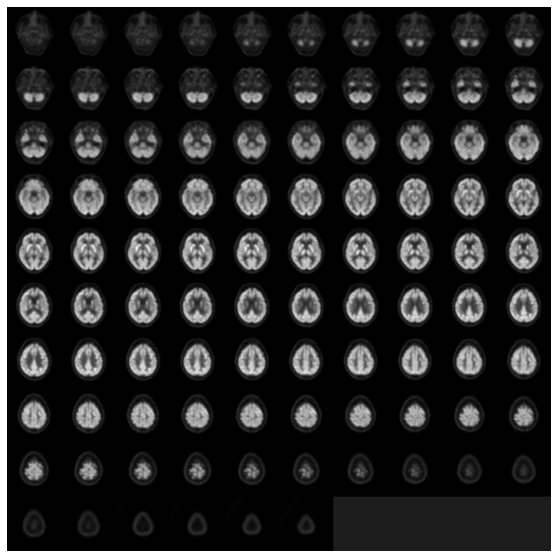

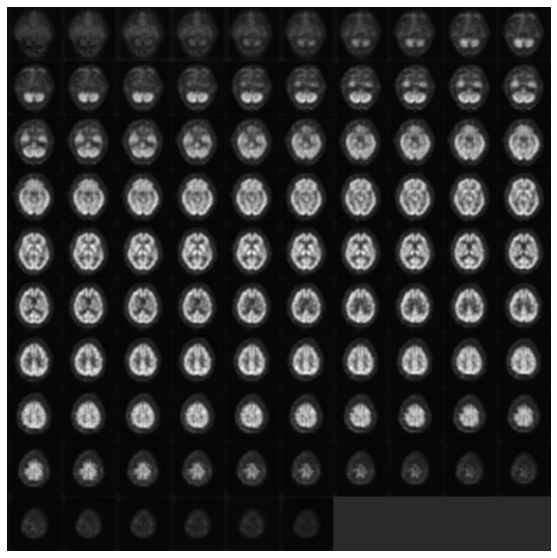

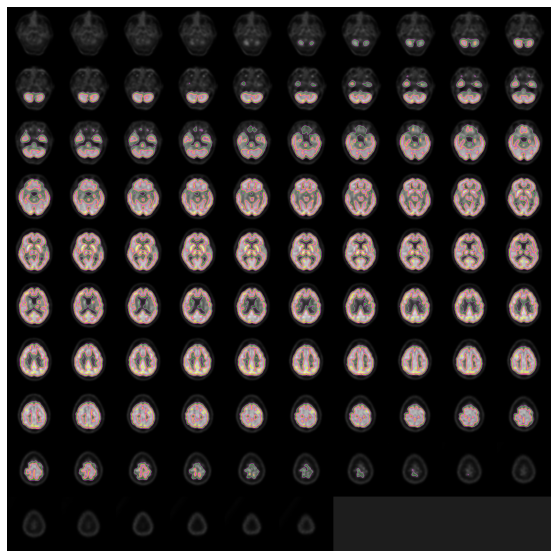

In [195]:
show_reconstruction(xs[0], logits['dec2'][0])